# Cross Validation
This notebook contains my own implementation of cross validation, and explores cross validation on a few models.

In [1]:
# load in the data
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

In [2]:
# see what data looks like
print(yTrain[0])
print(xTrain[0])

5
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 

In [3]:
# show some data examples
# may have to rerun to see images
import matplotlib.pyplot as plt

plt.imshow(xTrain[0])
plt.title('Image of ' + str(yTrain[0]))
plt.show()
plt.imshow(xTrain[1])
plt.title('Image of ' + str(yTrain[1]))
plt.show()
plt.imshow(xTrain[2])
plt.title('Image of ' + str(yTrain[2]))
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Cross Validation
### a. What is k-fold cross validation, and what is it used for?
k-fold cross validation is to split the data into k "folds" (k separate equally sized segments), and uses k-1 folds for training and 1 fold for testing to get an evaluation metric. The fold used for testing is varied each time so that use each of the k folds is the test set once. We will then have k evaluation metrics. We use k-fold cross validation to minimize bias in the training, and to obtain a distribution of evaluation metrics. We can assess a model better with a distribution rather than a single value.

### b. Create my of k-fold cross validation method and comparison.

In [4]:
# imports needed
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import numpy as np

In [5]:
# define my own k-fold cross validation method
def my_cross_val_score(clf, X, Y, cv):
    
    scores = np.array([0]*cv, dtype='float32') # holds results
    
    # shuffle values
    state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(state)
    np.random.shuffle(Y)
    
    # create the folds
    foldLen = int(len(X) / cv)
    foldsX = []
    foldsY = []
    
    # fill folds with shuffled data
    for i in range(cv-1):
        foldsX.append(X[foldLen*i : foldLen*(i+1)])
        foldsY.append(Y[foldLen*i : foldLen*(i+1)])
        
    # put all remaining in last
    foldsX.append(X[foldLen*(cv-1):])
    foldsY.append(Y[foldLen*(cv-1):])
    
    # get accuracy on each fold
    for i in range(cv):
        # all folds but one
        trainX = []
        [trainX.extend(fold) for fold in 
                  [f for j,f in enumerate(foldsX) if j != i]]
        # all folds but one
        trainY = []
        [trainY.extend(fold) for fold in 
                  [f for j,f in enumerate(foldsY) if j != i]]
            
        clf.fit(trainX, trainY)
        
        # evaluate on the one fold
        scores[i] = clf.score(foldsX[i], foldsY[i])
        
        
    return scores

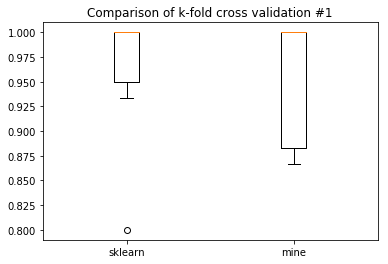

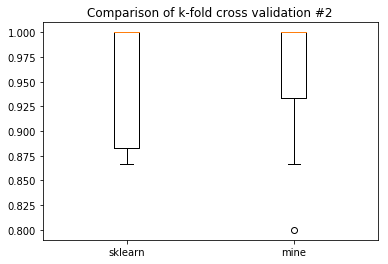

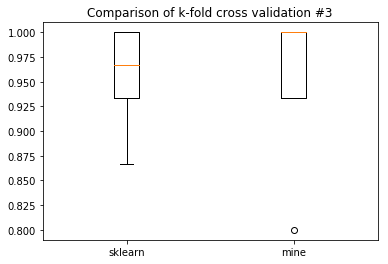

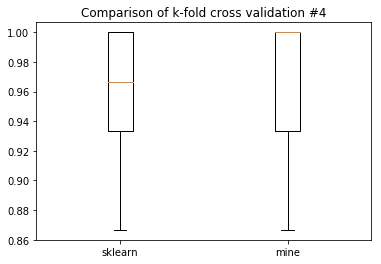

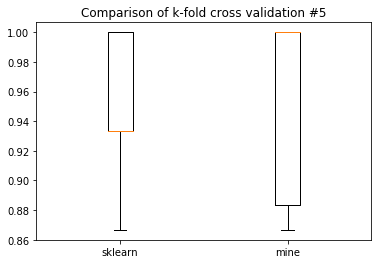

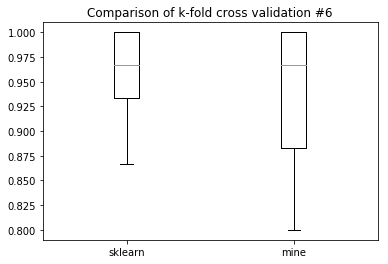

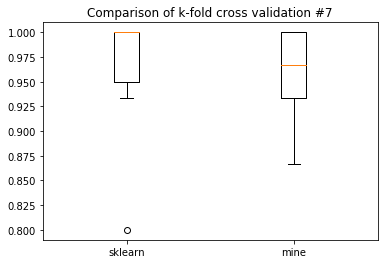

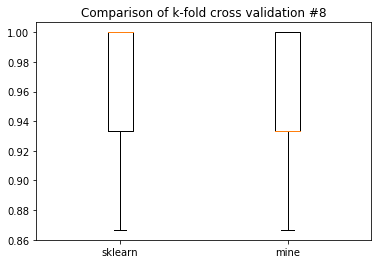

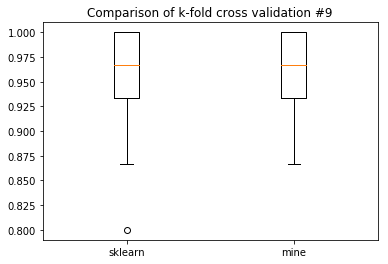

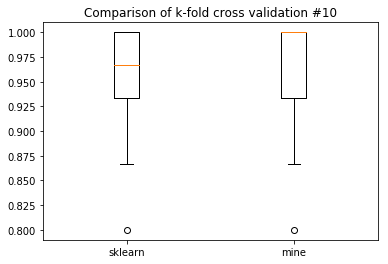

In [6]:
# comparison
iris = datasets.load_iris()
svm = LinearSVC()

# compare 10 times
for i in range(10):
    scoresSklearn = cross_val_score(svm, iris.data, iris.target, cv=10)
    scoresMine = my_cross_val_score(svm, iris.data, iris.target, 10)
    plt.boxplot([scoresSklearn, scoresMine], labels=['sklearn', 'mine'])
    plt.title('Comparison of k-fold cross validation #' + str(i+1))
    plt.show()

My implementation seems to do just about what sklearn's does.

### c. Compare SVM and RF with cross validation

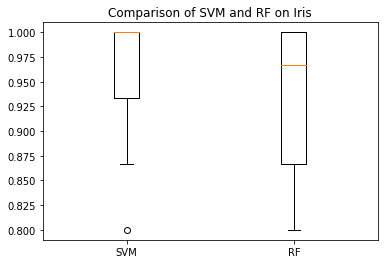

In [7]:
# create models
svm = LinearSVC()
rf = RandomForestClassifier()


# cross validate them
scoresSvm = cross_val_score(svm, iris.data, iris.target, cv=10)
scoresRf = cross_val_score(rf, iris.data, iris.target, cv=10)

# compare
plt.boxplot([scoresSvm, scoresRf], labels=['SVM', 'RF'])
plt.title('Comparison of SVM and RF on Iris')
plt.show()

After multiple evaluations, there cannot be made any conclusion on which method is better for this task (assuming default parameters). Also, results are volatile/varied due to the small dataset.

## Some model training and predictions

### Methodology
I will do a grid search and 5-fold cross validation on each of the models. I will select whichever model appears to do well. Then I will do a final fit on that model with the parameters found in the grid search, on 4/5ths of the train data, and check the results with the remaining 1/5th. Then I will make my predictions for the test set.

In [8]:
# new imports needed
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [9]:
features = ['x1','x2','x3','x4 ','x5','x6','x7','x8','x9','x10','x11','x12']
dfTrain = pd.read_csv('wine.train', header=None, names=['y','x1','x2','x3','x4 ','x5','x6','x7','x8','x9','x10','x11','x12']) 
dfTrain.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2.00000,13.070667,2.356833,2.370917,19.540000,98.958333,2.251333,1.931417,0.358917,1.529250,5.325667,0.934000,2.566333
std,0.81992,0.785123,1.091626,0.259544,3.282585,12.726863,0.638112,0.997697,0.129256,0.517255,2.358825,0.221232,0.733345
min,1.00000,11.610000,0.890000,1.700000,11.200000,78.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000
25%,1.00000,12.407500,1.660000,2.230000,16.950000,88.750000,1.700000,0.950000,0.260000,1.140000,3.490000,0.757500,1.820000
50%,2.00000,13.110000,1.895000,2.360000,19.500000,98.000000,2.200000,2.030000,0.335000,1.545000,5.050000,0.950000,2.760000
75%,3.00000,13.695000,3.047500,2.560000,21.500000,106.250000,2.742500,2.807500,0.455000,1.870000,6.652500,1.095000,3.170000
max,3.00000,14.830000,5.800000,3.220000,28.500000,151.000000,3.880000,3.740000,0.660000,2.910000,13.000000,1.360000,4.000000


In [10]:
# scale values from 0 to min with min max scaling
for f in features:
    dfTrain[f] = (dfTrain[f]-dfTrain[f].min())/(dfTrain[f].max()-dfTrain[f].min())
dfTrain.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2.00000,0.453623,0.298744,0.441393,0.482081,0.287100,0.438391,0.468064,0.431918,0.447700,0.345193,0.515909,0.474847
std,0.81992,0.243827,0.222327,0.170753,0.189745,0.174341,0.220038,0.293440,0.243880,0.206902,0.201265,0.251400,0.268625
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,0.247671,0.156823,0.348684,0.332370,0.147260,0.248276,0.179412,0.245283,0.292000,0.188567,0.315341,0.201465
50%,2.00000,0.465839,0.204684,0.434211,0.479769,0.273973,0.420690,0.497059,0.386792,0.454000,0.321672,0.534091,0.545788
75%,3.00000,0.647516,0.439409,0.565789,0.595376,0.386986,0.607759,0.725735,0.613208,0.584000,0.458404,0.698864,0.695971
max,3.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
mlp = GridSearchCV(MLPClassifier(max_iter=2000), 
    {'hidden_layer_sizes' : [(30,30), (100,50,30), (50,50,50,50,50),
                             (100,100,100,100,100)],
     'learning_rate_init' : [0.001, 0.0005, 0.003],
     'alpha' : [0.0001, 0.0005, 0.0005, 0.001]},
    cv=5)

mlp.fit(dfTrain.drop('y', axis=1), dfTrain['y'])
mlp.grid_scores_

/home/amaral/anaconda2/envs/pods/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.95000, std: 0.04859, params: {'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.001},
 mean: 0.95000, std: 0.04082, params: {'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.0005},
 mean: 0.96667, std: 0.03118, params: {'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.003},
 mean: 0.97500, std: 0.03333, params: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.001},
 mean: 0.95833, std: 0.02635, params: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.0005},
 mean: 0.95833, std: 0.04564, params: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.003},
 mean: 0.96667, std: 0.03118, params: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50, 50, 50), 'learning_rate_init': 0.001},
 mean: 0.95000, std: 0.06124, params: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50, 50, 50), 'learning_rate_init': 0.0005},
 mean: 0.95000

In [12]:
rfc = GridSearchCV(RandomForestClassifier(), 
    {'n_estimators' : [5,10,20,50,100,200,300]},
    cv=5)

rfc.fit(dfTrain.drop('y', axis=1), dfTrain['y'])
rfc.grid_scores_

/home/amaral/anaconda2/envs/pods/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.91667, std: 0.05893, params: {'n_estimators': 5},
 mean: 0.92500, std: 0.06667, params: {'n_estimators': 10},
 mean: 0.96667, std: 0.03118, params: {'n_estimators': 20},
 mean: 0.95833, std: 0.06455, params: {'n_estimators': 50},
 mean: 0.96667, std: 0.04859, params: {'n_estimators': 100},
 mean: 0.96667, std: 0.04859, params: {'n_estimators': 200},
 mean: 0.96667, std: 0.03118, params: {'n_estimators': 300}]

In [13]:
svc = GridSearchCV(SVC(), 
    {'kernel' : ['linear','poly','rbf','sigmoid'],
     'degree' : [1,2,3,4,5]},
    cv=5)

svc.fit(dfTrain.drop('y', axis=1), dfTrain['y'])
svc.grid_scores_

/home/amaral/anaconda2/envs/pods/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.93333, std: 0.04249, params: {'degree': 1, 'kernel': 'linear'},
 mean: 0.93333, std: 0.05652, params: {'degree': 1, 'kernel': 'poly'},
 mean: 0.94167, std: 0.05652, params: {'degree': 1, 'kernel': 'rbf'},
 mean: 0.94167, std: 0.05652, params: {'degree': 1, 'kernel': 'sigmoid'},
 mean: 0.93333, std: 0.04249, params: {'degree': 2, 'kernel': 'linear'},
 mean: 0.89167, std: 0.07728, params: {'degree': 2, 'kernel': 'poly'},
 mean: 0.94167, std: 0.05652, params: {'degree': 2, 'kernel': 'rbf'},
 mean: 0.94167, std: 0.05652, params: {'degree': 2, 'kernel': 'sigmoid'},
 mean: 0.93333, std: 0.04249, params: {'degree': 3, 'kernel': 'linear'},
 mean: 0.78333, std: 0.11304, params: {'degree': 3, 'kernel': 'poly'},
 mean: 0.94167, std: 0.05652, params: {'degree': 3, 'kernel': 'rbf'},
 mean: 0.94167, std: 0.05652, params: {'degree': 3, 'kernel': 'sigmoid'},
 mean: 0.93333, std: 0.04249, params: {'degree': 4, 'kernel': 'linear'},
 mean: 0.68333, std: 0.14337, params: {'degree': 4, 'kernel': '

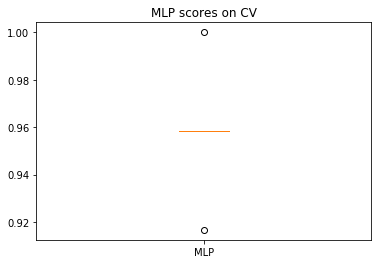

In [14]:
# I like MLP the most here because there is generally lower variance,
# and seemingly slightly better average performance.
# 'alpha': 0.0005, 'hidden_layer_sizes': (50, 50, 50, 50, 50), 'learning_rate_init': 0.001
# reaffirm results of a promising model
mlp = MLPClassifier(max_iter=2000, 
                    alpha=0.0005, 
                    hidden_layer_sizes=(50,50,50,50,50), 
                    learning_rate_init=0.001)
scores = cross_val_score(mlp, 
                         dfTrain.drop('y', axis=1), 
                         dfTrain['y'], 
                         cv=5)
# show results of final model on cv
plt.boxplot([scores], labels=['MLP'])
plt.title('MLP scores on CV')
plt.show()

In [15]:
# shuffle the train data
dfTrain = dfTrain.sample(frac=1).reset_index(drop=True)
dfVal = dfTrain.tail(20)
dfTrain = dfTrain.head(100)

In [16]:
# fit model and test on small 1/5th
from sklearn.metrics import accuracy_score
mlp.fit(dfTrain.drop('y', axis=1), dfTrain['y'])
print(accuracy_score(dfVal['y'], mlp.predict(dfVal.drop('y', axis=1))))

0.95


In [17]:
# get test data
dfTest = pd.read_csv('wine.test', header=None, names=['y','x1','x2','x3','x4 ','x5','x6','x7','x8','x9','x10','x11','x12']) 
# scale values from 0 to min with min max scaling
for f in features:
    dfTest[f] = (dfTest[f]-dfTest[f].min())/(dfTest[f].max()-dfTest[f].min())
dfTest.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,58.0,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.0,0.544982,0.316490,0.533376,0.453697,0.340892,0.531277,0.368453,0.390537,0.410901,0.326771,0.371398,0.583202
std,0.0,0.254687,0.239676,0.163041,0.179475,0.185524,0.245798,0.217046,0.266789,0.208510,0.253802,0.212232,0.271861
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.376119,0.160896,0.450535,0.353093,0.195652,0.335744,0.222838,0.209302,0.294304,0.128251,0.209821,0.357884
50%,0.0,0.531343,0.212831,0.540107,0.432990,0.304348,0.557851,0.388027,0.325581,0.379747,0.259456,0.401786,0.628631
75%,0.0,0.776119,0.469959,0.633690,0.536082,0.413043,0.726240,0.531042,0.534884,0.507911,0.450355,0.506696,0.788382
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# get prediction of test set
pred = mlp.predict(dfTest.drop('y', axis=1))

In [19]:
# save prediction (for assignment evaluation, true labels not given in test data)
np.savetxt("amaral.csv", pred, delimiter=",")